In [1]:
%pylab inline
import time

import pandas as pd
import anndata

import torch

from scvi.dataset import GeneExpressionDataset
from scvi.models import LDVAE
from scvi.inference import UnsupervisedTrainer
from scvi.inference.posterior import Posterior

Populating the interactive namespace from numpy and matplotlib


In [2]:
adata = anndata.read('cao_atlas.h5ad')

In [3]:
idx = adata.obs.query('detected_doublet == "False"').index

In [4]:
adata = adata[idx]

In [6]:
X, local_means, local_vars, batch_indices, labels = \
GeneExpressionDataset.get_attributes_from_matrix(adata.X)

In [7]:
cells_dataset = \
GeneExpressionDataset(X, local_means, local_vars, batch_indices, labels,
                      gene_names=np.array(adata.var.index.values, dtype=str))

In [8]:
cells_dataset.subsample_genes(1000)

Downsampling from 26183 to 1000 genes
Downsampling from 1949131 to 1949131 cells


In [9]:
vae = LDVAE(cells_dataset.nb_genes, reconstruction_loss='nb')

In [10]:
trainer = UnsupervisedTrainer(vae, cells_dataset, use_cuda=True)

In [11]:
trainer.train(n_epochs=3)

training: 100%|█████████████████████████████████████████████████████████████████████████| 3/3 [15:01<00:00, 289.32s/it]


In [54]:
g_df = pd.DataFrame(index=cells_dataset.gene_names)
g_df['gene_name'] = adata.var.loc[g_df.index]['gene_short_name']

In [55]:
W, b = list(vae.get_loadings())
b = b.detach().cpu().numpy()
W = W.detach().cpu().numpy()

for i, w in enumerate(W.T):
    g_df[f'w{i}'] = w

In [56]:
g_df['length'] = np.linalg.norm(W, axis=1)

In [60]:
g_df.sort_values('length', ascending=False).head(20)[['gene_name', 'length']]

,gene_name,length
ENSMUSG00000092204.1,Vmn2r-ps49,2.446012
ENSMUSG00000041380.13,Htr2c,2.360992
ENSMUSG00000000263.15,Glra1,2.223781
ENSMUSG00000097156.7,Gm3764,2.218418
ENSMUSG00000100341.1,Gm29478,2.062112
ENSMUSG00000029368.10,Alb,2.010207
ENSMUSG00000090059.4,Olfr1062,1.876483
ENSMUSG00000109741.1,Gm45455,1.858456
ENSMUSG00000052305.6,Hbb-bs,1.856343
ENSMUSG00000001506.10,Col1a1,1.801157


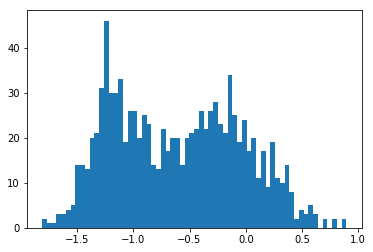

In [71]:
g_df.length.pipe(np.log).hist(bins=64, grid=False);

In [75]:
full = trainer.create_posterior(trainer.model, cells_dataset, indices=np.arange(len(cells_dataset)))

In [78]:
latent, batch_indices, labels = full.get_latent()

In [80]:
latent.shape

(1949131, 10)

In [86]:
c_df = pd.DataFrame(index=adata.obs.index)

In [95]:
for i, z in enumerate(latent.T):
    c_df[f'z{i}'] = z

In [157]:
import datashader as ds
import datashader.transfer_functions as tf
from datashader.utils import export_image

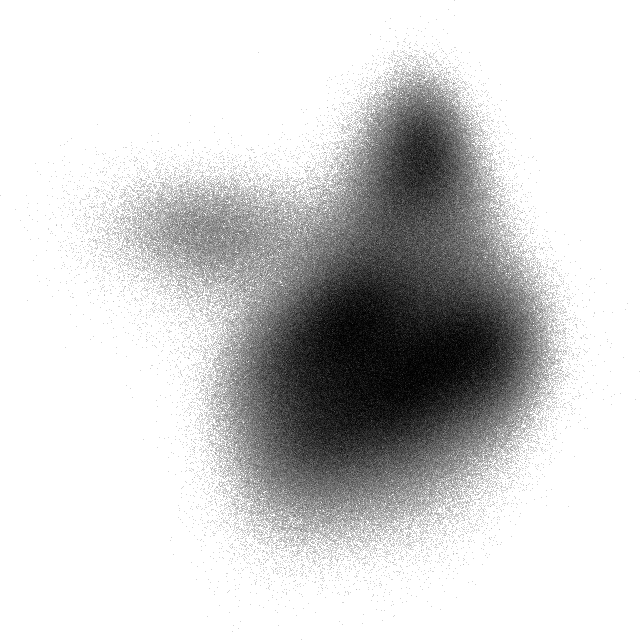

In [163]:
cvs = ds.Canvas(plot_width=640, plot_height=640)
agg = cvs.points(c_df, 'z0', 'z1')
img = tf.shade(agg, cmap=['lightgrey', 'black'])
export_image(img, 'figures/z0z1')

In [113]:
g_df['w0w1l'] = np.linalg.norm(W[:, :2], axis=1)

In [137]:
ggg = g_df.sort_values('w0w1l', ascending=False).head(16)[['gene_name', 'w0', 'w1', 'w0w1l']]
ggg

,gene_name,w0,w1,w0w1l
ENSMUSG00000041380.13,Htr2c,0.909841,1.662038,1.894777
ENSMUSG00000092204.1,Vmn2r-ps49,1.347310,0.575984,1.465266
ENSMUSG00000052305.6,Hbb-bs,1.178559,0.645647,1.343823
ENSMUSG00000001506.10,Col1a1,1.330341,0.186389,1.343334
ENSMUSG00000036815.16,Dpp10,0.729509,1.038239,1.268907
ENSMUSG00000085757.7,1700019B21Rik,1.032789,0.713449,1.255254
ENSMUSG00000022053.13,Ebf2,0.501975,-1.049333,1.163219
ENSMUSG00000090059.4,Olfr1062,1.105814,0.344646,1.158277
ENSMUSG00000056755.13,Grm7,0.835436,0.754038,1.125400
ENSMUSG00000064293.14,Cntn4,0.598807,0.949108,1.122219


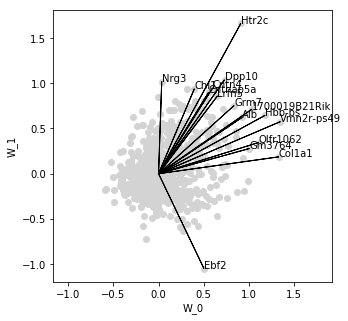

In [145]:
figsize(5, 5)
plt.scatter(g_df.w0, g_df.w1, c='lightgrey')
for g, r in ggg.iterrows():
    plt.arrow(0, 0, r.w0, r.w1, length_includes_head=True)
    plt.annotate(r.gene_name, (0, 0), xytext=(r.w0, r.w1))
    
plt.axis('equal');
plt.xlabel('W_0')
plt.ylabel('W_1');

In [164]:
c_df.to_csv('cao_linear_Z.csv')

In [165]:
g_df.to_csv('cao_linear_W.csv')